# Import Required Libraries
Import the necessary libraries for building and training the GAN model, as well as utilities for data handling and visualization.

In [15]:
import os
import numpy as np
import torch
from torch import nn, optim
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import dill
import warnings
warnings.filterwarnings("ignore", message=".*cudnnException.*")

# Define Dataset Class
We create a custom dataset class to load pairs of original and masked images. The images are assumed to have the same name, with `_masked` appended to the masked image files.

In [16]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class ImageMaskDataset(Dataset):
    """
    Custom Dataset to load original and masked image pairs.
    Assumes original images and masked images have the same name,
    with `_masked` appended to the masked images.
    """
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.image_files = [f for f in os.listdir(directory) if not f.endswith("_masked.jpg")]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        original_name = self.image_files[idx]
        masked_name = original_name.replace(".jpg", "_masked.jpg")

        original_path = os.path.join(self.directory, original_name)
        masked_path = os.path.join(self.directory, masked_name)

        # Load images
        original_img = Image.open(original_path).convert("RGB")
        masked_img = Image.open(masked_path).convert("RGB")

        if self.transform:
            original_img = self.transform(original_img)
            masked_img = self.transform(masked_img)

        return masked_img, original_img

# Define transformations to normalize image pixels to [0, 1]
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors (auto-normalized to [0, 1])
])

# Base directory for the dataset
base_dir = os.path.join("..", "Dataset")

# Directories for train, validation, and test sets
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

# Initialize datasets
train_dataset = ImageMaskDataset(train_dir, transform=transform)
val_dataset = ImageMaskDataset(val_dir, transform=transform)
test_dataset = ImageMaskDataset(test_dir, transform=transform)

# Data loaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify dataset sizes and loader functionality
print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")


Train samples: 9440, Validation samples: 1350, Test samples: 2710


# Define the Generator
The generator reconstructs original images from masked images by learning to map the masked inputs to the target distribution.

In [17]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)  # Residual connection

class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Global average pooling
            nn.Conv2d(channels, channels // reduction, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        attention_weights = self.attention(x)
        return x * attention_weights

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=kernel_size, padding=(kernel_size // 2), bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        attention_input = torch.cat([avg_out, max_out], dim=1)
        attention_weights = self.attention(attention_input)
        return x * attention_weights

class ImageReconstructionModel(nn.Module):
    def __init__(self):
        super(ImageReconstructionModel, self).__init__()

        # Encoder
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # Downsample
            nn.ReLU(inplace=True),
            SpatialAttention(kernel_size=7),  # Add spatial attention
            nn.Dropout(0.3)  # Add dropout for regularization
        )
        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Downsample
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            ChannelAttention(128),  # Add channel attention
            nn.Dropout(0.3)  # Add dropout for regularization
        )
        self.encoder3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Downsample
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            ChannelAttention(256),  # Add channel attention
            nn.Dropout(0.3)  # Add dropout for regularization
        )

        # Bottleneck with Residual Blocks
        self.bottleneck = nn.Sequential(
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256)
        )

        # Decoder
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Upsample
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            ResidualBlock(128),
            SpatialAttention(kernel_size=7)  # Add spatial attention
        )
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Upsample
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            ResidualBlock(64),
            SpatialAttention(kernel_size=7)  # Add spatial attention
        )
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),  # Final upsample
            nn.Sigmoid()  # Normalize output to [0, 1]
        )

        # Skip connection layers with attention
        self.skip1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=1),  # Align encoder1 channels with decoder2
            nn.BatchNorm2d(128),
            ChannelAttention(128)
        )
        self.skip2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=1),  # Align encoder2 channels with bottlenecked
            nn.BatchNorm2d(256),
            ChannelAttention(256)
        )

        # Refinement layer for fine details
        self.refinement = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            ResidualBlock(64),
            ResidualBlock(64),  # Additional residual block for finer details
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid()  # Normalize output to [0, 1]
        )

    def forward(self, x):
        # Encode
        enc1 = self.encoder1(x)  # 64 channels
        enc2 = self.encoder2(enc1)  # 128 channels
        enc3 = self.encoder3(enc2)  # 256 channels

        # Bottleneck
        bottlenecked = self.bottleneck(enc3)

        # Decode with skip connections
        # Align spatial dimensions and channels of skip2(enc2) with bottlenecked
        aligned_enc2 = nn.functional.interpolate(enc2, size=bottlenecked.shape[2:], mode="bilinear", align_corners=False)
        aligned_enc2 = self.skip2(aligned_enc2)  # Match channels to bottlenecked (256)

        dec1 = self.decoder1(bottlenecked + aligned_enc2)  # Combine bottleneck with encoder2 features

        # Align spatial dimensions and channels of skip1(enc1) with dec1
        aligned_enc1 = nn.functional.interpolate(enc1, size=dec1.shape[2:], mode="bilinear", align_corners=False)
        aligned_enc1 = self.skip1(aligned_enc1)  # Match channels to dec1 (128)

        dec2 = self.decoder2(dec1 + aligned_enc1)  # Combine decoder1 with encoder1 features

        # Final reconstruction
        dec3 = self.decoder3(dec2)

        # Refinement for fine details
        refined = self.refinement(dec3)

        return refined

# Instantiate Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImageReconstructionModel().to(device)
print(model)


ImageReconstructionModel(
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): SpatialAttention(
      (attention): Sequential(
        (0): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (1): Sigmoid()
      )
    )
    (3): Dropout(p=0.3, inplace=False)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ChannelAttention(
      (attention): Sequential(
        (0): AdaptiveAvgPool2d(output_size=1)
        (1): Conv2d(128, 8, kernel_size=(1, 1), stride=(1, 1))
        (2): ReLU(inplace=True)
        (3): Conv2d(8, 128, kernel_size=(1, 1), stride=(1, 1))
        (4): Sigmoid()
      )
    )
    (4): Dropout(p=0.3, inplace=False)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kerne

# Define Loss Functions and Optimizers
We use Binary Cross-Entropy Loss (BCE) for both the generator and discriminator. Adam optimizers are used for both networks.

# Validation Function
The `validate` function evaluates the generator on the validation dataset. 
It computes the combined adversarial and reconstruction losses for the generated images.

# Visualize Generated Images
Compare the masked, generated, and original images to evaluate the GAN's performance.

In [18]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def visualize_reference_images(model, reference_images_dir, transform, grid_size=5):
    """
    Visualizes masked and reconstructed images in a 4-row grid:
    - Row 1: Original masked images (first set)
    - Row 2: Reconstructed images (first set)
    - Row 3: Original masked images (second set)
    - Row 4: Reconstructed images (second set)
    
    Args:
        model (torch.nn.Module): Trained model for image reconstruction.
        reference_images_dir (str): Directory containing masked images.
        transform (callable): Transform to preprocess images (e.g., normalization, ToTensor).
        grid_size (int): Number of images per row.
    """
    model.eval()  # Ensure the model is in evaluation mode

    # Load masked images
    masked_image_files = sorted(os.listdir(reference_images_dir))
    masked_images = []
    for file_name in masked_image_files[:2 * grid_size]:  # Limit to the first 2 * grid_size images
        image_path = os.path.join(reference_images_dir, file_name)
        image = Image.open(image_path).convert("RGB")  # Open image in RGB format
        masked_images.append(transform(image))  # Apply transformations (e.g., ToTensor)

    # Stack into a batch and move to the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    masked_images = torch.stack(masked_images).to(device)  # Shape: [batch_size, channels, height, width]

    # Generate reconstructed images
    with torch.no_grad():
        reconstructed_images = model(masked_images)  # Model output
        reconstructed_images = reconstructed_images.cpu()  # Move to CPU for visualization

    # Convert tensors to numpy arrays for plotting
    masked_images_np = (masked_images.permute(0, 2, 3, 1) * 255.0).cpu().numpy().astype(np.uint8)
    reconstructed_images_np = (reconstructed_images.permute(0, 2, 3, 1) * 255.0).numpy().astype(np.uint8)

    # Visualization with a 4-row grid
    fig, axs = plt.subplots(4, grid_size, figsize=(15, 12))  # 4 rows, grid_size columns

    # First set of images (rows 1 and 2)
    for i in range(grid_size):
        # Row 1: Masked images
        axs[0, i].imshow(masked_images_np[i])
        axs[0, i].axis("off")
        axs[0, i].set_title(f"Masked {i+1}", fontsize=16)

        # Row 2: Reconstructed images
        axs[1, i].imshow(reconstructed_images_np[i])
        axs[1, i].axis("off")
        axs[1, i].set_title(f"Reconstructed {i+1}", fontsize=16)

    # Second set of images (rows 3 and 4)
    for i in range(grid_size, 2 * grid_size):
        # Row 3: Masked images
        axs[2, i - grid_size].imshow(masked_images_np[i])
        axs[2, i - grid_size].axis("off")
        axs[2, i - grid_size].set_title(f"Masked {i+1}", fontsize=16)

        # Row 4: Reconstructed images
        axs[3, i - grid_size].imshow(reconstructed_images_np[i])
        axs[3, i - grid_size].axis("off")
        axs[3, i - grid_size].set_title(f"Reconstructed {i+1}", fontsize=16)

    plt.tight_layout()
    plt.show()


# Training Loop
The GAN is trained by alternately updating the generator and discriminator. The generator tries to fool the discriminator, while the discriminator tries to correctly classify real and fake images.

In [19]:
class DynamicWeightedMSELoss(nn.Module):
    def __init__(self, alpha=10):
        super(DynamicWeightedMSELoss, self).__init__()
        self.alpha = alpha  # Scale factor for weighting

    def forward(self, reconstructed, original):
        # Compute absolute difference
        diff = torch.abs(reconstructed - original)
        
        # Emphasize dark reconstructed pixels far from the original
        weights = 1 + self.alpha * (1 - reconstructed) * diff

        # Apply weighted MSE
        loss = weights * (reconstructed - original) ** 2
        return loss.mean()


# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the correct device
model = model.to(device)

criterion_dynamic_mse = DynamicWeightedMSELoss(alpha=10).to(device)

# Optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# History to track training progress
history = {"train_loss": [], "val_loss": []}
epochs = 50

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    # Training phase
    for masked_image, original_image in train_loader:
        # Move data to the correct device
        masked_image, original_image = masked_image.to(device), original_image.to(device)

        # Forward pass
        optimizer.zero_grad()
        reconstructed = model(masked_image)

        # Compute loss
        loss = criterion_dynamic_mse(reconstructed, original_image)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    history["train_loss"].append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for masked_image, original_image in val_loader:
            # Move data to the correct device
            masked_image, original_image = masked_image.to(device), original_image.to(device)

            # Forward pass
            reconstructed = model(masked_image)

            # Compute validation loss
            loss = criterion_dynamic_mse(reconstructed, original_image)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    history["val_loss"].append(val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Adjust learning rate
    scheduler.step()


Epoch 1/50, Train Loss: 0.0180, Val Loss: 0.0103
Epoch 2/50, Train Loss: 0.0106, Val Loss: 0.0081
Epoch 3/50, Train Loss: 0.0090, Val Loss: 0.0072
Epoch 4/50, Train Loss: 0.0079, Val Loss: 0.0054
Epoch 5/50, Train Loss: 0.0071, Val Loss: 0.0108
Epoch 6/50, Train Loss: 0.0065, Val Loss: 0.0049
Epoch 7/50, Train Loss: 0.0061, Val Loss: 0.0049
Epoch 8/50, Train Loss: 0.0059, Val Loss: 0.0045
Epoch 9/50, Train Loss: 0.0056, Val Loss: 0.0049
Epoch 10/50, Train Loss: 0.0054, Val Loss: 0.0096
Epoch 11/50, Train Loss: 0.0048, Val Loss: 0.0039
Epoch 12/50, Train Loss: 0.0047, Val Loss: 0.0040
Epoch 13/50, Train Loss: 0.0046, Val Loss: 0.0035
Epoch 14/50, Train Loss: 0.0045, Val Loss: 0.0038
Epoch 15/50, Train Loss: 0.0045, Val Loss: 0.0037
Epoch 16/50, Train Loss: 0.0044, Val Loss: 0.0035
Epoch 17/50, Train Loss: 0.0043, Val Loss: 0.0038
Epoch 18/50, Train Loss: 0.0043, Val Loss: 0.0035
Epoch 19/50, Train Loss: 0.0042, Val Loss: 0.0043
Epoch 20/50, Train Loss: 0.0041, Val Loss: 0.0036
Epoch 21/

# Train the GAN
Train the GAN using the training dataset for a specified number of epochs.

# Plot Training and Validation Losses
This function plots the generator's training and validation losses (`g_loss` and `val_g_loss`), as well as the discriminator's loss (`d_loss`). Validation loss is plotted with a dashed line for better distinction.

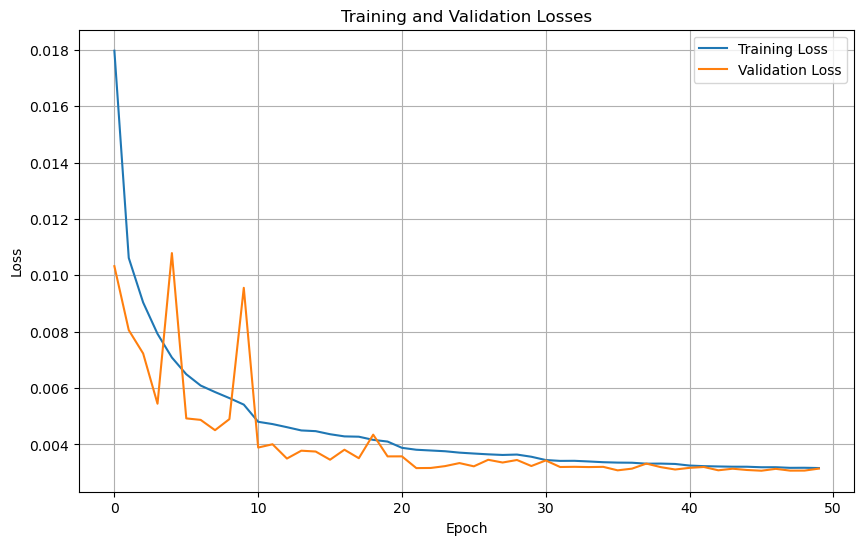

In [20]:
def plot_losses(history):
    plt.figure(figsize=(10, 6))

    # Plot training loss
    plt.plot(history["train_loss"], label="Training Loss")
    
    # Plot validation loss
    plt.plot(history["val_loss"], label="Validation Loss")
    
    # Add labels, title, and legend
    plt.title("Training and Validation Losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

# Call the function
plot_losses(history)


## Evaluation of GAN on Test Set
This section evaluates the GAN's generator on the test set, computing the **Mean Squared Error (MSE)** and **Mean Absolute Error (MAE)** for the generated images compared to the originals.


In [21]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Lists to store MSE and MAE for each image
mse_list = []
mae_list = []

# Evaluate on the test set
print("Evaluating the Attention Model on the test set...")
with torch.no_grad():
    for masked_images, original_images in test_loader:
        masked_images = masked_images.to(device)
        original_images = original_images.to(device)

        # Generate reconstructed images using the attention-based model
        reconstructed_images = model(masked_images)

        # Un-normalize images to [0, 255] and convert to numpy arrays
        unnormalized_reconstructed_images = (reconstructed_images * 255).clamp(0, 255).cpu().numpy().astype(np.uint8)
        unnormalized_original_images = (original_images * 255).clamp(0, 255).cpu().numpy().astype(np.uint8)

        # Flatten and compute MSE/MAE for each pair of images
        for reconstructed, original in zip(unnormalized_reconstructed_images, unnormalized_original_images):
            mse_list.append(mean_squared_error(original.flatten(), reconstructed.flatten()))
            mae_list.append(mean_absolute_error(original.flatten(), reconstructed.flatten()))

# Calculate average MSE and MAE
average_mse = np.mean(mse_list)
average_mae = np.mean(mae_list)

# Print final results
print(f"Test Results - Average MSE: {average_mse:.2f}")
print(f"Test Results - Average MAE: {average_mae:.2f}")


Evaluating the Attention Model on the test set...
Test Results - Average MSE: 30.46
Test Results - Average MAE: 92.14


# Test Set Visualization
Display masked, generated, and original images from the test set.

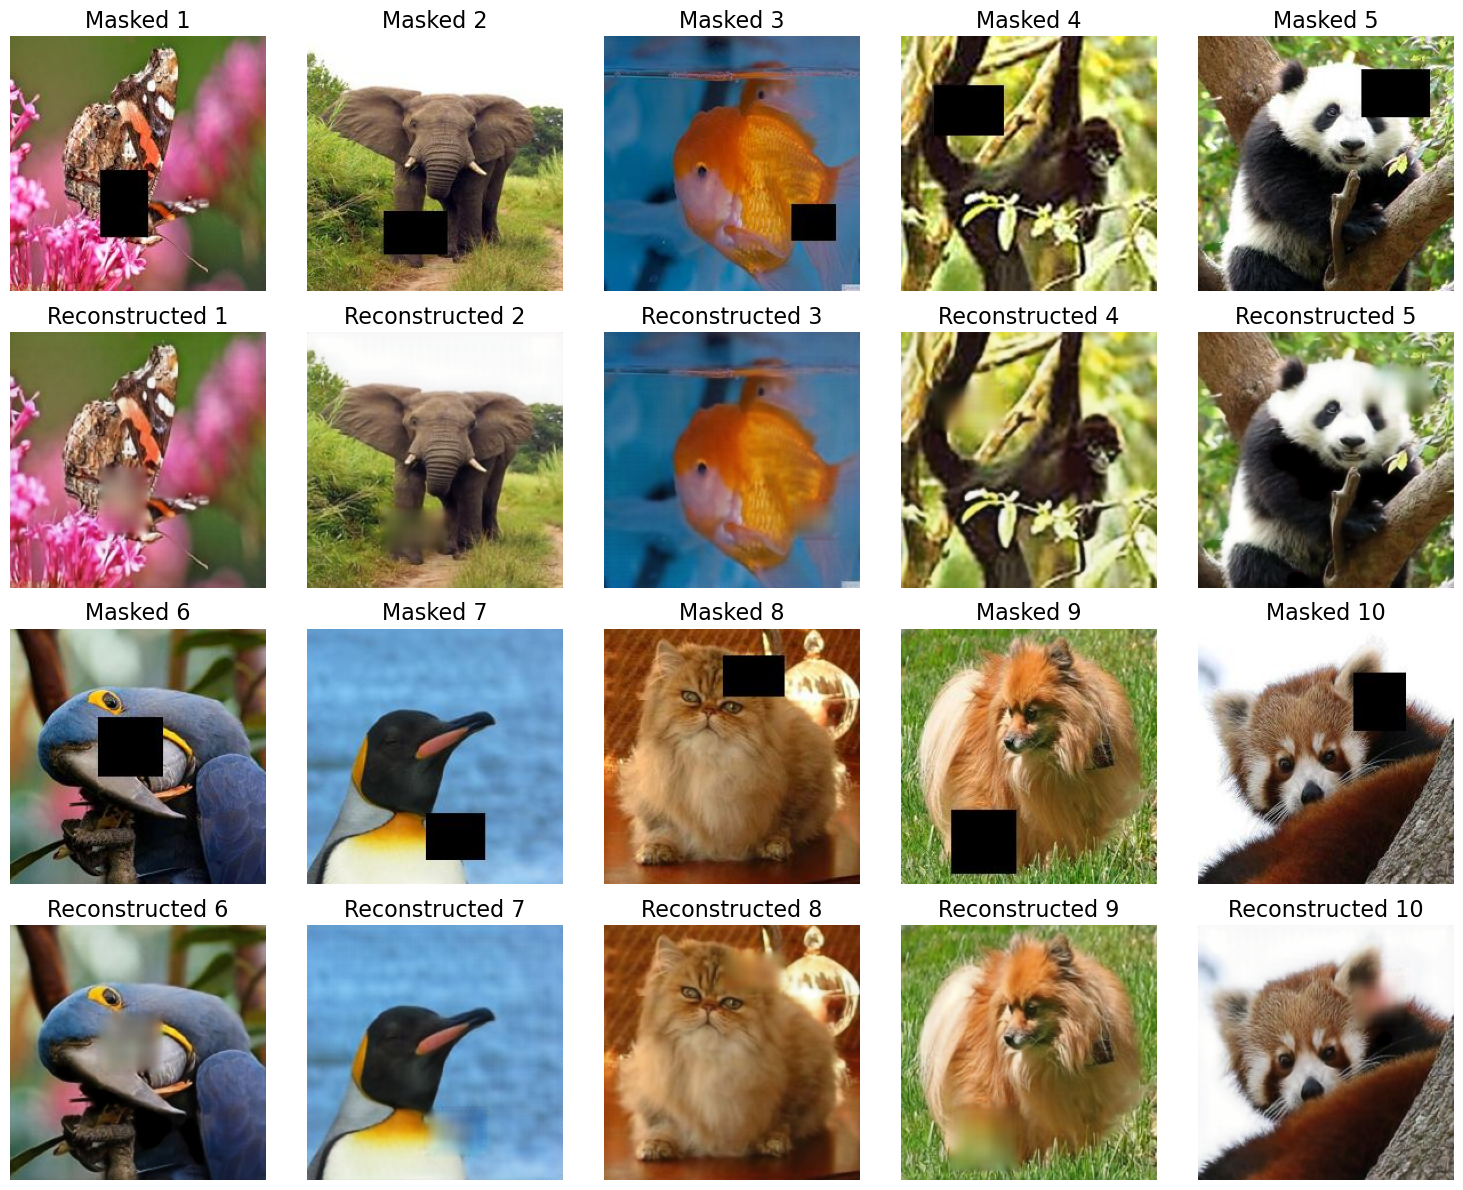

In [22]:
# Path to reference images
reference_images_dir = os.path.join("..", "Reference_Images")

# Visualize a few images of the train set
visualize_reference_images(model, reference_images_dir, transform)

# Save Trained Models
Save the trained generator and discriminator models to a specified directory for later validation or reuse.

In [23]:
import os
import torch
import dill

# Parent directory for saving models
parent_dir = os.path.join("..", "saved_models", "AttentionModels")

# Create the parent directory if it doesn't exist
if not os.path.exists(parent_dir):
    os.makedirs(parent_dir)

# Define the name and path for the subdirectory
sub_dir_name = "Small_training_testing"
sub_dir_path = os.path.join(parent_dir, sub_dir_name)

# Create the subdirectory if it doesn't exist
if not os.path.exists(sub_dir_path):
    os.makedirs(sub_dir_path)

# Define file path for saving the attention model
model_path = os.path.join(sub_dir_path, "attention_model_full.pth")

# Save the full model using dill as the pickle module
torch.save(model, model_path, pickle_module=dill)

# Inform the user of the save location
print(f"Full Attention model saved to: {model_path}")


Full Attention model saved to: ..\saved_models\AttentionModels\Small_training_testing\attention_model_full.pth
